In [1]:
import os
import cv2
import numpy as np
import torch
from skimage import transform as sktsf
from torchvision import transforms as tvtsf
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
def normalize(img):
    """
    https://github.com/pytorch/vision/issues/223
    return appr -1~1 RGB
    """
    normalizing = tvtsf.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    img = normalizing(torch.from_numpy(img).float())
    return img.numpy()

In [82]:
def resize_bbox(bbox, in_size, out_size):
    """Resize bounding boxes according to image resize.
    The bounding boxes are expected to be packed into a two dimensional
    tensor of shape :math:`(R, 4)`, where :math:`R` is the number of
    bounding boxes in the image. The second axis represents attributes of
    the bounding box. They are :math:`(y_{min}, x_{min}, y_{max}, x_{max})`,
    where the four attributes are coordinates of the top left and the
    bottom right vertices.
    Args:
        bbox (~numpy.ndarray): An array whose shape is :math:`(R, 4)`.
            :math:`R` is the number of bounding boxes.
        in_size (tuple): A tuple of length 2. The height and the width
            of the image before resized.
        out_size (tuple): A tuple of length 2. The height and the width
            of the image after resized.
    Returns:
        ~numpy.ndarray:
        Bounding boxes rescaled according to the given image shapes.
    """
    bbox = bbox.copy()
    y_scale = float(out_size[0]) / in_size[0]
    x_scale = float(out_size[1]) / in_size[1]
    bbox[:, 0] = y_scale * bbox[:, 0]
    bbox[:, 2] = y_scale * bbox[:, 2]
    bbox[:, 1] = x_scale * bbox[:, 1]
    bbox[:, 3] = x_scale * bbox[:, 3]
    return bbox.astype(int)

In [91]:
# https://github.com/chenyuntc/simple-faster-rcnn-pytorch/blob/master/data/dataset.py#L42
def preprocess(img, min_size=600, max_size=1000):
    """Preprocess an image for feature extraction.
    The length of the shorter edge is scaled to :obj:`self.min_size`.
    After the scaling, if the length of the longer edge is longer than
    :param min_size:
    :obj:`self.max_size`, the image is scaled to fit the longer edge
    to :obj:`self.max_size`.
    After resizing the image, the image is subtracted by a mean image value
    :obj:`self.mean`.
    Args:
        img (~numpy.ndarray): An image. This is in CHW and RGB format.
            The range of its value is :math:`[0, 255]`.
    Returns:
        ~numpy.ndarray: A preprocessed image.
    """
    C, H, W = img.shape
    scale1 = min_size / min(H, W)
    scale2 = max_size / max(H, W)
    scale = min(scale1, scale2)
    img = img / 255.
    img = sktsf.resize(img, (C, H * scale, W * scale), mode='reflect',anti_aliasing=False)
    # both the longer and shorter should be less than
    # max_size and min_size

    return normalize(img)

In [92]:
class Transform:

    def __init__(self, min_size=600, max_size=1000):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape
        img = preprocess(img, self.min_size, self.max_size)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = resize_bbox(bbox, (H, W), (o_H, o_W))

        return img, bbox, label, scale

In [93]:
transforms = Transform()

In [94]:
# https://github.com/chenyuntc/simple-faster-rcnn-pytorch/blob/0.4/data/dataset.py
# https://github.com/chainer/chainercv/blob/v0.12.0/chainercv/datasets/voc/voc_bbox_dataset.py#L11

class LoadDataset(Dataset):
    def __init__(self, data_dir, split='trainval', use_difficult=False, return_difficult=False, train=True, transform=transforms):
        # data_pth = /VOCdevkit/VOC2007
        id_list_file = os.path.join(data_dir, 'ImageSets/Main/{}.txt'.format(split))
        assert os.path.exists(id_list_file) == True , "file:{} not found.".format(id_list_file)
        with open(id_list_file, 'r') as f:
            id_lines = f.read().splitlines()
        self.ids = id_lines
        self.data_dir = data_dir
        self.use_difficult = use_difficult
        self.return_difficult = return_difficult
        self.train = train
        self.transform = transforms
        VOC_BBOX_LABEL_NAMES = (
            'aeroplane',
            'bicycle',
            'bird',
            'boat',
            'bottle',
            'bus',
            'car',
            'cat',
            'chair',
            'cow',
            'diningtable',
            'dog',
            'horse',
            'motorbike',
            'person',
            'pottedplant',
            'sheep',
            'sofa',
            'train',
            'tvmonitor')
        self.label_names = VOC_BBOX_LABEL_NAMES
        
    def __len__(self):
        return len(self.ids)
    
    def _get_image(self, i):
        img_path = os.path.join(self.data_dir, 'JPEGImages', i + '.jpg')
        img = cv2.imread(img_path) # BGR, (333, 500, 3)
        img = np.transpose(img,(2,0,1)) # # RBG, (3, 333, 500)
        assert img is not None, 'File Not Found: {}'.format(img_path)
        return img
    
    def _get_annotations(self, i):
        anno = ET.parse(os.path.join(self.data_dir, 'Annotations', i + '.xml'))
        bbox, label, difficult = [], [], []
        
        for obj in anno.findall('object'):
            # when in not using difficult split, and the object is
            # difficult, skipt it.
            if not self.use_difficult and int(obj.find('difficult').text) == 1:
                continue
            
            difficult.append(int(obj.find('difficult').text))
            bndbox_anno = obj.find('bndbox')
            bbox.append([int(bndbox_anno.find(tag).text)-1 for tag in ('xmin', 'ymin', 'xmax', 'ymax')])
            name = obj.find('name').text.lower().strip()
            label.append(self.label_names.index(name))
            
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)
        difficult = np.array(difficult, dtype=np.bool).astype(np.uint8)
        
        return bbox, label, difficult

    def __getitem__(self, idx):
        indx = self.ids[idx]
        img = self._get_image(indx)
        bbox, label, difficult = self._get_annotations(indx)
        if self.train:
            img, bbox, label, scale = self.transform((img, bbox, label))
        
        return img, bbox, label, difficult

In [87]:
t = 'E:/data/voc07/VOCdevkit/VOC2007'

In [122]:
dataset = LoadDataset(t,train=False)

In [123]:
len(dataset)

5011

In [124]:
img = dataset[3][0]

In [125]:
img.shape

(3, 333, 500)

In [126]:
img = np.transpose(img,(1,2,0))

In [127]:
img.shape

(333, 500, 3)

In [128]:
dataset[3][1]

array([[155.,  96., 350., 269.]], dtype=float32)

In [129]:
dataset[3][2]

array([6])

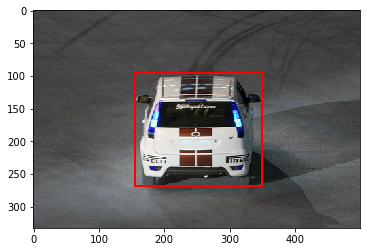

In [130]:
cv2.rectangle(img, (155,96), (350,269), (255,0,0), 2)
plt.imshow(img)
plt.show()

In [60]:
def show_one_image(dataset, num=None):
    if num == None:
        num = np.random.randint(0,len(dataset))
    img, bbox, label, _ = dataset[num][0], dataset[num][1], dataset[num][2], dataset[num][3]
    img = np.transpose(img,(1,2,0))
    for i in range(len(bbox)):
        x1, y1, x2, y2 = bbox[i][0], bbox[i][1], bbox[i][2], bbox[i][3]
        cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
    plt.imshow(img)
    plt.show()

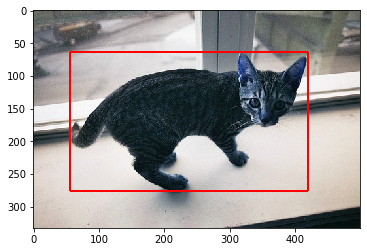

In [61]:
show_one_image(dataset)

In [21]:
# transform

In [131]:
dataset1 = LoadDataset(t, train=True)

In [132]:
len(dataset1)

5011

In [133]:
img1 = dataset1[3][0]

In [ ]:
img1.shape 

In [134]:
"""
im_data: torch.size([1,3,600,901]);
im_info: tensor([[600.0000, 901.0000,   1.8018]], device='cuda:0');
num_box: tensor([1], device='cuda:0')
gt_box:
tensor([[[279.2793, 172.9730, 630.6306, 484.6847,   7.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]]], device='cuda:0')
         label: 7, background:0, 6+1=7
"""

(3, 600, 901)

In [135]:
img2 = np.transpose(img1,(1,2,0))

In [136]:
img2.shape

(600, 901, 3)

In [137]:
dataset1[3][1]

array([[279, 172, 630, 484]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


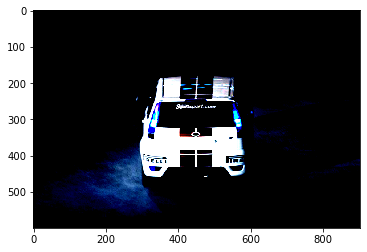

In [138]:
cv2.rectangle(img2, (279,172), (630,484), (255,0,0), 2)
plt.imshow(img2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


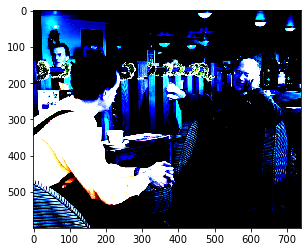

In [139]:
show_one_image(dataset1)